## Import Packages

In [28]:
import cv2
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

import os 

%matplotlib inline

print("...")

...


## Calibrate Camera Using Chessboard Pattern

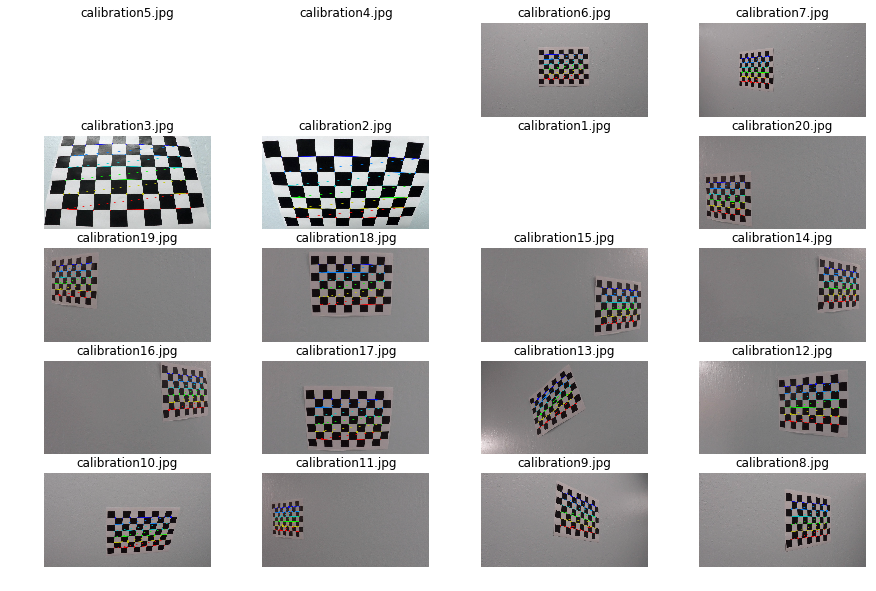

In [2]:
# create lists to store object points and image points from all pattern views 
# (i.e. images where all corners will be found)
## object points: 3D-points in real world coordinates
object_pts_list = [] 
## image points: 2D-points in (virtual) image plane
img_pts_list = [] 

# prepare object points for a given pattern view / image
## each image contains 6*9 corners, i.e. points of contact between two black squares: 9 per row * 6 per column
object_pts = np.zeros((6*9,3), np.float32)
## (0,0,0), (1,0,0), ..., (8,0,0), (0,1,0), (1,1,0), ... with z coordinate always equal to zero
object_pts[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# create list of images to use for camera calibration
img_list = os.listdir('camera_cal/')

# set up subplot grid to show all images with corners drawn on them
fig, axes = plt.subplots(5, 4, figsize=(15, 10))
fig.subplots_adjust(hspace = .2, wspace= .2)
axes = axes.ravel()

# go through list of images
for idx, filename in enumerate(img_list):
    # load images
    img = cv2.imread("camera_cal/" + filename)
    # convert to grayscale
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # identify chessboard corners
    # returns non-zero return value and image points if all 9*6 corners are identified
    pattern_found, corners = cv2.findChessboardCorners(gray_img, (9, 6), flags = 
                                             cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)    
    # set title and switch of coordinate axes in respective subplot  
    axes[idx].axis('off')
    axes[idx].set_title(filename)
    
    # if all corners were identified in given image
    if pattern_found == True:
        # add object points to list of all object points 
        object_pts_list.append(object_pts)
        # refine image points
        # source: https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html
        refined_corners = cv2.cornerSubPix(gray_img, corners, (11, 11), (-1, -1),
                                           criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1))
        # add image points to list of all image points
        img_pts_list.append(refined_corners)
        # Draw the corners on the original image and display it
        corner_img = cv2.drawChessboardCorners(img, (9, 6), refined_corners, pattern_found)
        axes[idx].imshow(corner_img)

<p><center><em>If an image is not displayed, it means that cv2.findChessboardCorners() could not find all corners in it.</em></center></p>


In [3]:
# Calibrate camera given list of object points and list of image points
ret_val, intrinsics, dist_coeffs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_pts_list,
                                                                                        img_pts_list, 
                                                                                        img.shape[0:2],
                                                                                        None,
                                                                                        None)
print("...")

...


## Undistort Example Images Using Intrinsic Camera Matrix and Distortion Coefficients

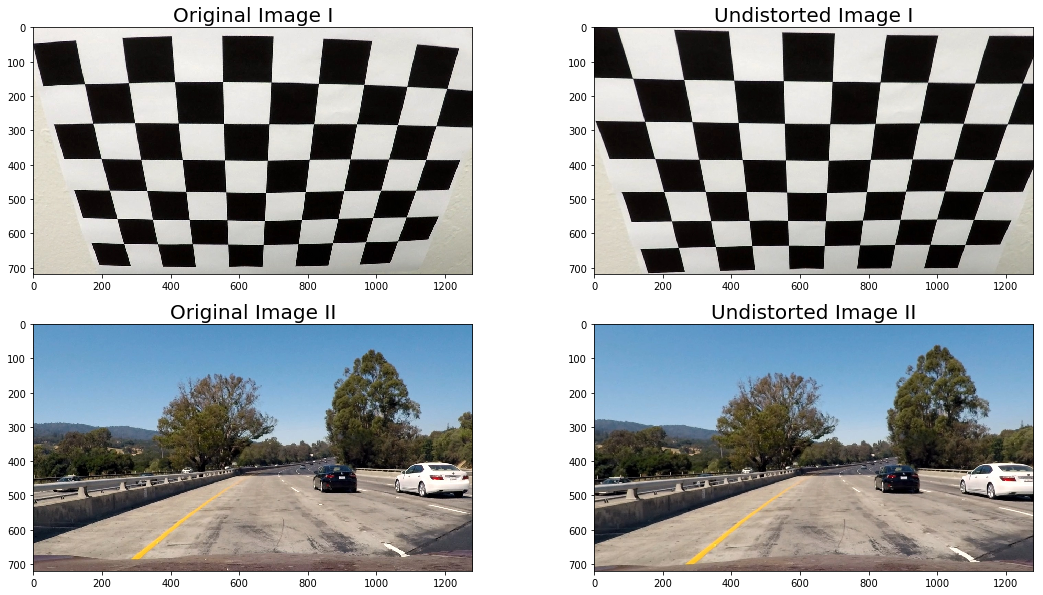

In [4]:
# Load and undistort images 
cb_img = cv2.imread('camera_cal/calibration2.jpg')
cc_img = cv2.imread('test_images/test1.jpg')
cb_img = cv2.cvtColor(cb_img, cv2.COLOR_BGR2RGB)
cc_img = cv2.cvtColor(cc_img, cv2.COLOR_BGR2RGB)
cb_undist_img = cv2.undistort(cb_img, intrinsics, dist_coeffs)
cc_undist_img = cv2.undistort(cc_img, intrinsics, dist_coeffs)

# Visualize undistorted images
fig, axes = plt.subplots(2, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.01)
axes = axes.ravel()

axes[0].imshow(cb_img)
axes[0].set_title('Original Image I', fontsize=20)
axes[1].imshow(cb_undist_img)
axes[1].set_title('Undistorted Image I', fontsize=20)

axes[2].imshow(cc_img)
axes[2].set_title('Original Image II', fontsize=20)
axes[3].imshow(cc_undist_img)
axes[3].set_title('Undistorted Image II', fontsize=20)

## Perspective Transform

**NOTE**: Fixed perspective transform below assumes a relatively flat road and fixed camera position

**TODO**: Make code more robust and usable in more challenging scenarios (e.g. `harder_challenge_video.mp4`)

In [5]:
def warp(img, src, dst):
    """
    Takes image 'img' as well as source 'src' and destination correspondence points 'dst' as input. 
    Returns warped image warped, transformation matrix 'M' and inverse transformation matrix 'M_inv'
    """
    img_height, img_width = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img_width,img_height), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv

print("...")

...


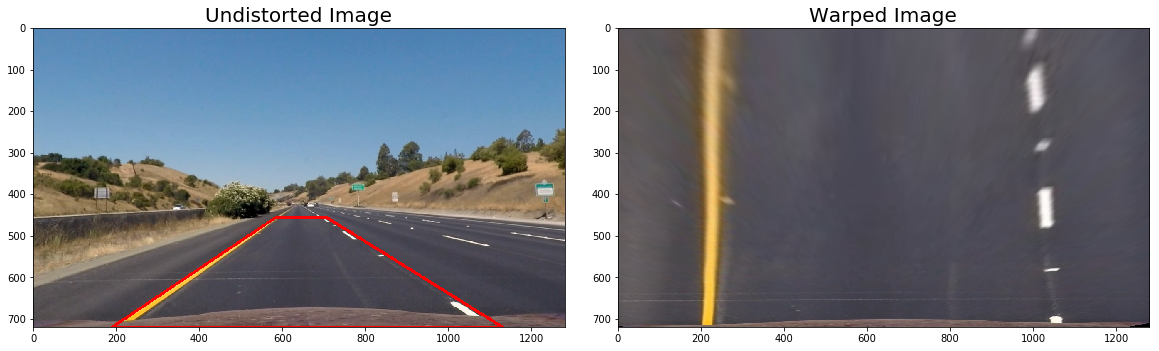

In [240]:
# load and undistort example image, from which to read the four pairs of corresponding points required for transform
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist_img = cv2.undistort(img, intrinsics, dist_coeffs)

# define source and destination correspondence points for transform
## take a look at example image and determine (x,y) coordinates of the lane
lane_top_y = 455
lane_bottom_y = img.shape[0]
lane_bottom_left_x = 190
lane_top_left_x = 585
lane_bottom_right_x = 1130
lane_top_right_x = 705

img_bottom_y = lane_bottom_y
img_top_y = 0 
img_left_x = 0
img_right_x = img.shape[1]

## define source points
src_cp_bottom_left = (lane_bottom_left_x, lane_bottom_y)
src_cp_top_left = (lane_top_left_x, lane_top_y)
src_cp_top_right = (lane_top_right_x, lane_top_y)
src_sp_bottom_right = (lane_bottom_right_x, lane_bottom_y)

src_cpts = np.float32([src_cp_bottom_left, 
                      src_cp_top_left, 
                      src_cp_top_right,
                      src_sp_bottom_right])

## define destination points
x_offset = 200

dst_cp_bottom_left = (img_left_x + x_offset, img_bottom_y)
dst_cp_top_left = (img_left_x + x_offset, img_top_y)
dst_cp_top_right = (img_right_x - x_offset, img_top_y)
dst_sp_bottom_right = (img_right_x - x_offset, img_bottom_y)

dst_cpts = np.float32([dst_cp_bottom_left, 
                       dst_cp_top_left,
                       dst_cp_top_right,
                       dst_sp_bottom_right])
   
# unwarp original image
warped_img, M, M_inv = warp(undist_img, src_cpts, dst_cpts)

# draw lines based on source points into original image
color = [255, 0, 0]
width = 5

# make a copy of undistorted image to draw on
copied_undist_img = np.copy(undist_img)

cv2.line(copied_undist_img, src_cp_bottom_left, src_cp_top_left, color, width)
cv2.line(copied_undist_img, src_cp_top_left, src_cp_top_right, color, width)
cv2.line(copied_undist_img, src_cp_top_right, src_sp_bottom_right, color, width)
cv2.line(undist_img, src_sp_bottom_right, src_cp_bottom_left, color, width)

# display undistorted image and warped version next to each other
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.1)
axes = axes.ravel()

axes[0].imshow(undist_img)
axes[0].set_title('Undistorted Image', fontsize=20)
axes[1].imshow(warped_img)
axes[1].set_title('Warped Image', fontsize=20)

## Visualize Multiple Color Space Channels

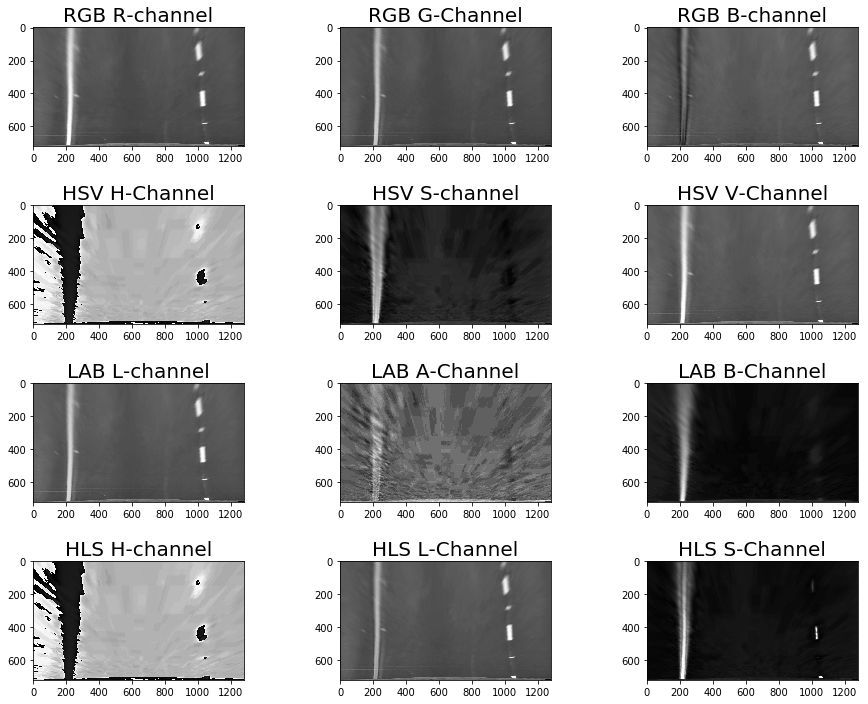

In [7]:
# Visualize multiple color space channels
# load image includign a 

## RGB color space
warped_img_R = warped_img[:,:,0]
warped_img_G = warped_img[:,:,1]
warped_img_B = warped_img[:,:,2]

## HSV color space
warped_img_HSV = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HSV)
warped_img_H = warped_img_HSV[:,:,0]
warped_img_S = warped_img_HSV[:,:,1]
warped_img_V = warped_img_HSV[:,:,2]

## LAB color space
warped_img_LAB = cv2.cvtColor(warped_img, cv2.COLOR_RGB2Lab)
warped_img_L = warped_img_LAB[:,:,0]
warped_img_A = warped_img_LAB[:,:,1]
warped_img_B2 = warped_img_LAB[:,:,2] # B2 as B already taken

## HLS color space
warped_img_HLS = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HLS)
warped_img_H2 = warped_img_HLS[:,:,0] # H2 as H already taken
warped_img_L2 = warped_img_HLS[:,:,1] # L2 as L already taken
warped_img_S2 = warped_img_HLS[:,:,2] # S2 as S already taken

## Setup and display subplots
fig, axes = plt.subplots(4,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .5, wspace=.1)
axes = axes.ravel()
axes[0].imshow(warped_img_R, cmap='gray')
axes[0].set_title('RGB R-channel', fontsize=20)
axes[1].imshow(warped_img_G, cmap='gray')
axes[1].set_title('RGB G-Channel', fontsize=20)
axes[2].imshow(warped_img_B, cmap='gray')
axes[2].set_title('RGB B-channel', fontsize=20)

axes[3].imshow(warped_img_H, cmap='gray')
axes[3].set_title('HSV H-Channel', fontsize=20)
axes[4].imshow(warped_img_S, cmap='gray')
axes[4].set_title('HSV S-channel', fontsize=20)
axes[5].imshow(warped_img_V, cmap='gray')
axes[5].set_title('HSV V-Channel', fontsize=20)

axes[6].imshow(warped_img_L, cmap='gray')
axes[6].set_title('LAB L-channel', fontsize=20)
axes[7].imshow(warped_img_A, cmap='gray')
axes[7].set_title('LAB A-Channel', fontsize=20)
axes[8].imshow(warped_img_B2, cmap='gray')
axes[8].set_title('LAB B-Channel', fontsize=20)

axes[9].imshow(warped_img_H2, cmap='gray')
axes[9].set_title('HLS H-channel', fontsize=20)
axes[10].imshow(warped_img_L2, cmap='gray')
axes[10].set_title('HLS L-Channel', fontsize=20)
axes[11].imshow(warped_img_S2, cmap='gray')
axes[11].set_title('HLS S-Channel', fontsize=20)

<p><center><em>S-channel of HLS color space shows strong contrast for yellow and white lines against the rest of the image</em></center></p>


## Sobel Absolute Threshold

In [8]:
def apply_threshold(img, thresh_min, thresh_max):
    """
    Applies a threshold to input image 'img' using interval ['thresh_min', 'thresh_max']
    and returns a binary image [0, 255]
    """
    binary_img = np.zeros_like(img)
    binary_img[(img >= thresh_min) & (img <= thresh_max)] = 1
    
    return binary_img
    
def absolute_sobel_thresh(img, dx = True, dy = False, thresh_min = 0, thresh_max = 255, kernel_size = 3):
    """
    For some grayscale input image 'img', calculates the Sobel gradient on the direction 'dx' or 'dy'
    and returns a binary image using interval ['thresh_min', 'thresh_max'] using kernel size 'kernel_size'
    """
    # determine the gradient image on the direction dx or dy
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize = kernel_size)
    
    # take the absolute value 
    abs_sobel = np.absolute(sobel)
    
    # scale to 8-bit (0-255) before converting to type = np.uint8
    scaled = np.uint8(255.0 * abs_sobel / np.max(abs_sobel))
    
    return apply_threshold(scaled, thresh_min, thresh_max)

print('...')


...


In [11]:
def change_thresh_orient(min_thresh, max_thresh, dx, dy):
    """
    Serves as input to ipywidgets.interact() allowing to interactively determine the 
    best combination of threshold values 'min_thresh' and 'max_thresh'
    """
    abs_sobel_img = absolute_sobel_thresh(warped_img_S2, dx, dy, min_thresh, max_thresh)
    
    # visualize sobel absolute threshold
    fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (20, 10))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axis1.imshow(warped_img_S2, cmap = 'gray')
    axis1.set_title('Warped Image', fontsize = 20)
    axis2.imshow(abs_sobel_img, cmap = 'gray')
    axis2.set_title('Sobel Absolute Threshold Image', fontsize = 20)

print('...')

...


### Sobel Absolute Threshold with `orient = 'x'`

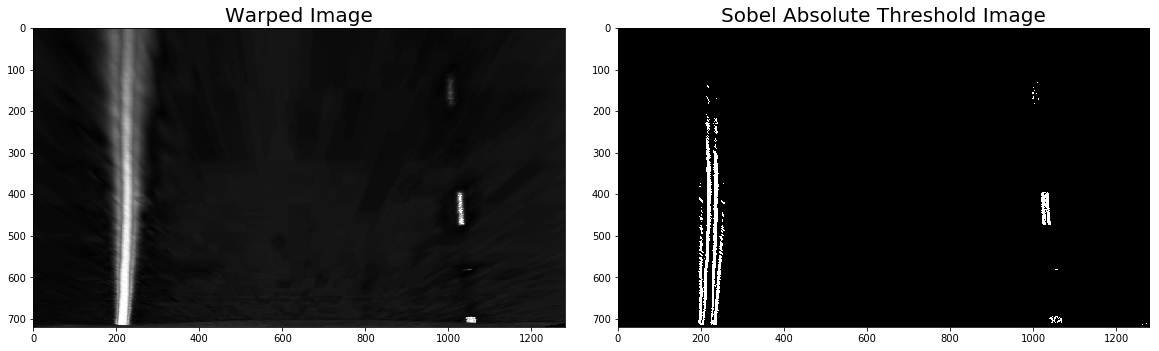

In [12]:
interact(change_thresh_orient,
         min_thresh = (0,255),
         max_thresh = (0,255),
         dx = True,
         dy=False)

### Sobel Absolute Threshold with `orient = 'y'`

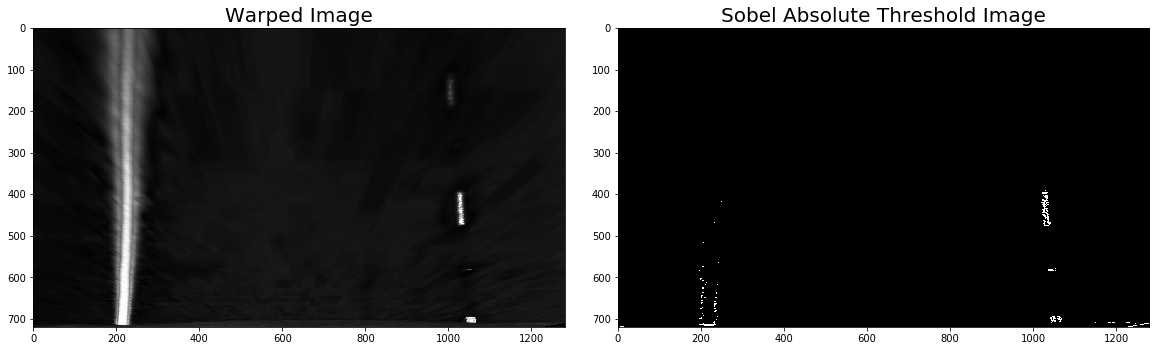

In [13]:
interact(change_thresh_orient,
         min_thresh=(0, 255),
         max_thresh=(0, 255),
         dx = False,
         dy = True)

## Sobel Magnitude Threshold

In [14]:
def magnitude_sobel_thresh(img, thresh_min = 0, thresh_max = 255, kernel_size = 3):
    """
    For some grayscale input image 'img', calculates the Sobel gradient on the direction 
    'dx' and 'dy' separately, then computes the magnitude of the gradient, 
    and returns a binary image using interval ['thresh_min', 'thresh_max'] and kernel size 'kernel_size'
    """
    # calculate the gradient (in x- and y-direction separately)
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = kernel_size)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = kernel_size)
    
    # calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    
    # scale to 8-bit (0-255) before converting to type = np.uint8
    scaled = np.uint8(255.0 * mag_sobel / np.max(mag_sobel))
    
    return apply_threshold(scaled, thresh_min, thresh_max)

print('...')


...


In [15]:
def change_thresh(min_thresh, max_thresh):
    """
    Serves as input to ipywidgets.interact() allowing to interactively determine the 
    best combination of threshold values 'min_thresh' and 'max_thresh'
    """
    mag_sobel_img = magnitude_sobel_thresh(warped_img_S2, min_thresh, max_thresh)
    
    # visualize sobel magnitude threshold
    fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (20, 10))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axis1.imshow(warped_img_S2, cmap = 'gray')
    axis1.set_title('Warped Image', fontsize = 20)
    axis2.imshow(mag_sobel_img, cmap = 'gray')
    axis2.set_title('Sobel Magnitude Threshold Image', fontsize = 20)

print('...')

...


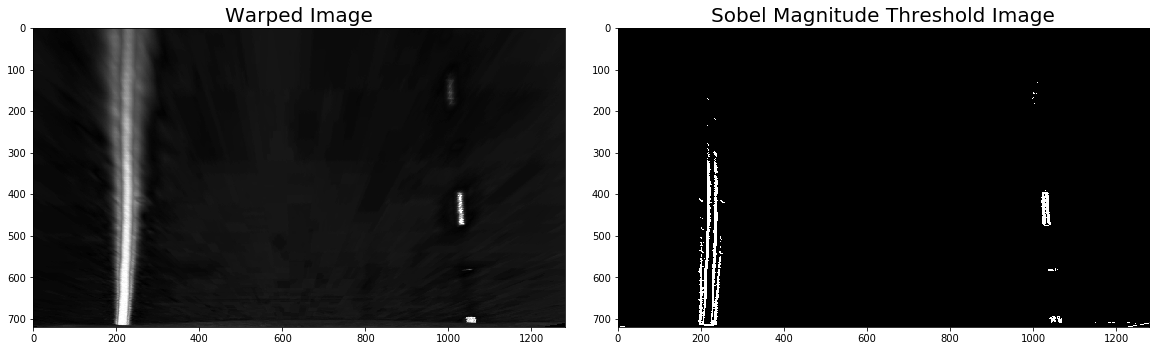

In [16]:
interact(change_thresh,
         min_thresh=(0, 255),
         max_thresh=(0, 255))

## Sobel Direction Threshold

In [17]:
def direction_sobel_thresh(img, thresh_min = 0, thresh_max = 255, kernel_size = 3):
    """
    For some grayscale input image 'img', calculates the Sobel gradient in the direction
    'dx' and 'dy' separately, then computes the direction of the gradient, 
    and returns a binary image using interval ['thresh_min', 'thresh_max'] and kernel size 'kernel_size'
    """
    # take the gradient (in x- and y-direction separately)
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = kernel_size)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = kernel_size)
    
    # calculate the absolute values 
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
 
    # calculate the direction of the gradient
    grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    return apply_threshold(grad_dir, thresh_min, thresh_max)

print('...')

...


In [20]:
def change_thresh_ksize(min_thresh, max_thresh, kernel_size):
    """
    Serves as input to ipywidgets.interact() allowing to interactively determine the 
    best combination of threshold values 'min_thresh' and 'max_thresh' and 'kernel_size'
    """
    dir_sobel_img = direction_sobel_thresh(warped_img_S2, min_thresh, max_thresh, kernel_size)
    
    # visualize sobel magnitude threshold
    fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (20, 10))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axis1.imshow(warped_img_S2, cmap = 'gray')
    axis1.set_title('Warped Image', fontsize = 20)
    axis2.imshow(dir_sobel_img, cmap = 'gray')
    axis2.set_title('Sobel Direction Threshold Image', fontsize = 20)

print('...')

...


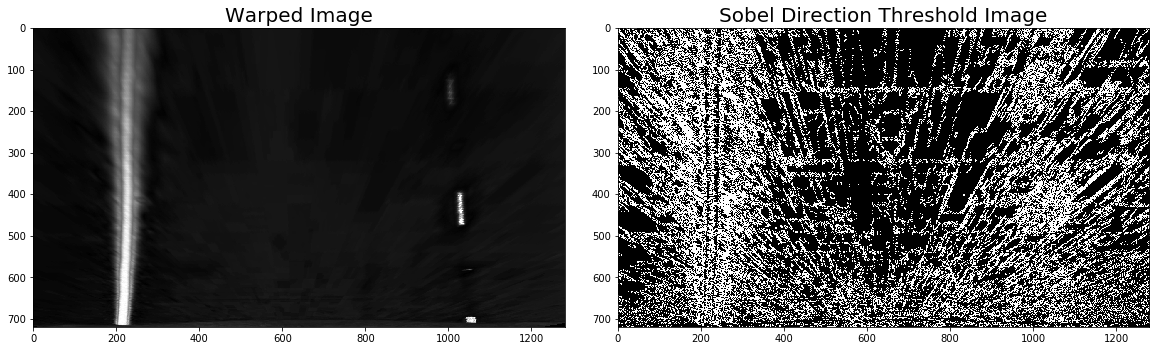

In [29]:
interact(change_thresh_ksize, kernel_size=(3,9,2), 
                 min_thresh=(0, np.pi/2, 0.01), 
                 max_thresh=(0, np.pi/2, 0.01))

## Sobel Magnitude + Direction Threshold

In [22]:
def mag_dir_sobel_thresh(img, 
                         mag_min_thresh = 20, mag_max_thresh = 160, mag_kernel_size = 3, 
                         dir_min_thresh = 0.2, dir_max_thresh = 1.2, dir_kernel_size = 3):
    """
    Combines Sobel magnitude threshold and Sobel direction threshold.
    Takes a binary image "img" as input.
    For Sobel magnitude threshold, takes as arguments the minimum threshold 'mag_min_thresh', 
    the maximum threshold 'mag_max_thresh', and the kernel size 'mag_kernel_size'.
    For Sobel minimum threshold, takes as arguments the minimum threshold 'dir_min_thresh', 
    the maximum threshold 'dir_max_thresh', and the kernel size 'dir_kernel_size'. 
    Returns combined mask of Sobel magnitude threshold and Sobel direction threshold
    """ 
    mag_sobel = magnitude_sobel_thresh(warped_img_S2, mag_min_thresh, mag_max_thresh, mag_kernel_size)
    dir_sobel = direction_sobel_thresh(warped_img_S2, dir_min_thresh, dir_max_thresh, dir_kernel_size)
    mag_dir_sobel = np.zeros_like(mag_sobel)
    mag_dir_sobel[((mag_sobel == 1) & (dir_sobel == 1))] = 1
    
    return mag_dir_sobel

print('...')

...


In [23]:
def change_threshs_ksizes(mag_min_thresh, mag_max_thresh, mag_kernel_size, 
                          dir_min_thresh, dir_max_thresh, dir_kernel_size):
    """
    Serves as input to ipywidgets.interact() allowing to interactively determine the 
    best combination of threshold values and kernel sizes for combined Sobel magnitude + direction threshold
    """    
    combined_sobel_img = mag_dir_sobel_thresh(warped_img_S2, 
                                              mag_min_thresh, mag_max_thresh, mag_kernel_size, 
                                              dir_min_thresh, dir_max_thresh, dir_kernel_size)
    
    # visualize sobel magnitude threshold
    fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (20, 10))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axis1.imshow(warped_img_S2, cmap = 'gray')
    axis1.set_title('Warped Image', fontsize = 20)
    axis2.imshow(combined_sobel_img, cmap = 'gray')
    axis2.set_title('Sobel Magnitude + Direction Threshold Image', fontsize = 20)

print('...')

...


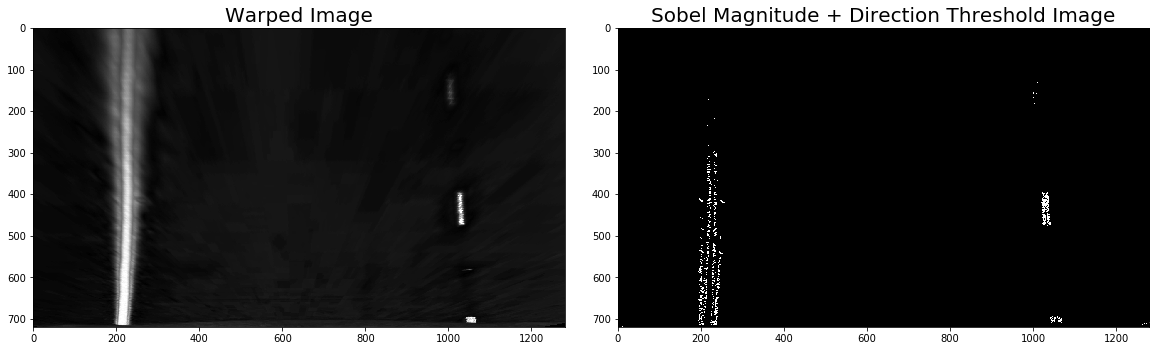

In [24]:
interact(change_threshs_ksizes, 
         mag_kernel_size=(3, 9, 2),
         mag_min_thresh=(0, 255),
         mag_max_thresh=(0, 255),
         dir_kernel_size=(3, 9, 2), 
         dir_min_thresh=(0, np.pi/2, 0.01), 
         dir_max_thresh=(0, np.pi/2, 0.01))

## Polyfit for Lane Line Identification in Binary Input Image

In [245]:
def polyfit_lane_lines(bin_img, windows = 10, window_width = 160, min_nonzero_pxs = 40):
    """
    Find the polynomial representation of the left and right lane line 
    in the input binary image 'bin_img' using sliding window.
    Takes as argument the number of windows stacked in y-direction 'windows', 
    the window width in x-direction 'window_width', 
    and the minimum number of nonzero pixels 'min_nonzero_pxs' found within given window to recenter the window.
    Returns tuple '(left_polyfit, right_polyfit)'
    """
    # determine sliding window params required below
    ## calculate sliding window height
    window_height = np.int(bin_img.shape[0] / windows)
    ## calculate half the width of sliding window
    half_win_width = np.int(window_width / 2)
    
    # Initialize empty lists in which to store left and right lane line pixel indices
    left_line_idxs = []
    right_line_idxs = []   
    
    # get x and y coordinates of all nonzero pixels in the input binary image
    nonzero_img_pxs = bin_img.nonzero()
    nonzero_x = np.array(nonzero_img_pxs[1]) #1-D array
    nonzero_y = np.array(nonzero_img_pxs[0]) #1-D array

    # get histogram of the bottom half of the image
    histogram = np.sum(bin_img[bin_img.shape[0] // 2:, :], axis=0)
    
    # find the peak of the left and right halves of the histogram
    # these peaks serve as starting points for the left and right lane lines
    half_img_width = np.int(bin_img.shape[0] / 2)
    left_line_x_start = np.argmax(histogram[:half_img_width])
    right_line_x_start = np.argmax(histogram[half_img_width:]) + half_img_width

    # Current x coordinates of left and right lane line (to be updated for each window)
    left_line_x_current = left_line_x_start
    right_line_x_current = right_line_x_start

    # go through all windows from bottom to top (one left and right window pair per layer)
    for i in range(windows):
        # determine window boundaries for left and right window at given layer 
        win_left_x_low = left_line_x_current - half_win_width
        win_left_x_high = left_line_x_current + half_win_width
        
        win_right_x_low = right_line_x_current - half_win_width
        win_right_x_high = right_line_x_current + half_win_width
        
        win_y_low = bin_img.shape[0] - (i + 1) * window_height
        win_y_high = bin_img.shape[0] - i * window_height        
        
        # identify nonzero pixels within the given left and right window
        ## check which elements (x, y coordinates of img pixels) of 'nonzero_x' and 'nonzero_y' are within window
        nonzero_px_within_left_window = np.all(((nonzero_x >= win_left_x_low),
                                                (nonzero_x < win_left_x_high),
                                                (nonzero_y >= win_y_low),
                                                (nonzero_y < win_y_high)), axis = 0)
        nonzero_px_within_right_window = np.all(((nonzero_x >= win_right_x_low),
                                                 (nonzero_x < win_right_x_high),
                                                 (nonzero_y >= win_y_low),
                                                 (nonzero_y < win_y_high)), axis = 0)
        
        ## get indices of elements for which above check evaluates to True in terms of 
        ## position in "nonzero_x" or "nonzero_y"
        nonzero_idxs_within_left_window = nonzero_px_within_left_window.nonzero()[0]
        nonzero_idxs_within_right_window = nonzero_px_within_right_window.nonzero()[0]
    
        ## append indices for left and right window to respective list 
        left_line_idxs.append(nonzero_idxs_within_left_window)
        right_line_idxs.append(nonzero_idxs_within_right_window)    
    
        # If window contains more than 'min_nonzero_pxs' nonzero pixels, recenter next window on their mean
        if len(nonzero_idxs_within_left_window) > min_nonzero_pxs:
            left_line_x_current = np.int(np.mean(nonzero_x[nonzero_idxs_within_left_window]))
        if len(nonzero_idxs_within_right_window) > min_nonzero_pxs:        
            right_line_x_current = np.int(np.mean(nonzero_x[nonzero_idxs_within_right_window]))

    # transform list of indices into np.array structure
    left_line_idxs = np.concatenate(left_line_idxs)
    right_line_idxs = np.concatenate(right_line_idxs)

    # determine left and right line pixel positions
    left_x = nonzero_x[left_line_idxs]
    right_x = nonzero_x[right_line_idxs]
    left_y = nonzero_y[left_line_idxs]
    right_y = nonzero_y[right_line_idxs] 

    left_polyfit, right_polyfit = (None, None)
    
    # fit a second order polynomial to left and right line pixels  
    # as straight line must be a possible result, use y-pixel-values as x-input for np.polyfit()
    if len(left_x) is not 0:
        left_polyfit = np.polyfit(x = left_y, y = left_x, deg = 2)
    if len(right_x) is not 0:
        right_polyfit = np.polyfit(x = right_y, y = right_x, deg = 2)
    
    return left_polyfit, right_polyfit

print('...')

...


In [263]:
def visualize_polyfitted_lines(bin_img, left_fit, right_fit):
    """
    Takes as input binary image 'bin_img',
    and polynomial coefficients for left and right polyfit curves 'left_fit' and 'right_fit'.
    Outputs the input image including the fitted lane lines
    """
    # determine height of input image 
    img_height = bin_img.shape[0]

    # generate x and y values for plotting curves 
    # NOTE: as straight line must be a possible result, y-values were used as x-input to np.polyfit()
    ys = np.linspace(start = 0, stop = img_height - 1, num = img_height)
    fitted_left_line_xs = left_fit[0] * ys **2 + left_fit[1] * ys + left_fit[2]
    fitted_right_line_xs = right_fit[0] * ys **2 + right_fit[1] * ys + right_fit[2]

    # plot binary image with polyfitted lines 
    fig, axis = plt.subplots(1, 1, figsize = (10, 5))
    axis.imshow(bin_img, cmap = 'gray')
    axis.plot(fitted_left_line_xs, ys, color = 'red')
    axis.plot(fitted_right_line_xs, ys, color = 'red')
    axis.set_title('Binary Image + Polyfitted Lane Lines', fontsize = 20)

print('...')

...


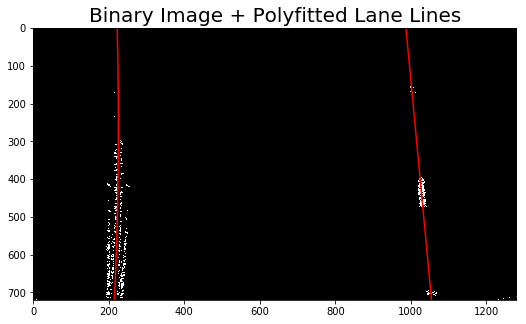

In [264]:
left_fit, right_fit = polyfit_lane_lines(combined_sobel_img)

visualize_polyfitted_lines(combined_sobel_img, left_fit, right_fit)

## Draw Lane Lines onto Undistorted Original Image

In [266]:
def draw_lane_lines(rgb_img, bin_img, left_fit, right_fit, M_inv):
    """
    Takes as input RGB image 'rgb_img', 
    its processed binary image 'bin_img' (warped and passed through Sobel thresholds),
    polynomial coefficients for left and right polyfit curves 'left_fit' and 'right_fit', 
    and the inverse transformation matrix M_inv.
    Returns the original image including the fitted left and right lane lines 'result'
    """
    # copy original image
    copied_img = np.copy(rgb_img)
    
    # if one of the lines is missing, return original image
    if left_fit is None or right_fit is None:
        return rgb_img
    
    # create blank image on which to draw lines 
    warped_blank_img_channel = np.zeros_like(bin_img).astype(np.uint8)
    warped_blank_img = np.dstack((warped_blank_img_channel, 
                                  warped_blank_img_channel, 
                                  warped_blank_img_channel))
    
    # determine height and width of input image 
    img_height, img_width = bin_img.shape
    
    # generate x and y values for plotting curves 
    # NOTE: as straight line must be a possible result, y-values were used as x-input to np.polyfit()
    ys = np.linspace(start = 0, stop = img_height - 1, num = img_height)
    fitted_left_line_xs = left_fit[0] * ys **2 + left_fit[1] * ys + left_fit[2]
    fitted_right_line_xs = right_fit[0] * ys **2 + right_fit[1] * ys + right_fit[2]
    
    # recast the x and y points into usable format for cv2.fillPoly()
    left_line_pxs = np.array([np.transpose(np.vstack([fitted_left_line_xs, ys]))])
    right_line_pxs = np.array([np.flipud(np.transpose(np.vstack([fitted_right_line_xs, ys])))])
    line_pxs = np.hstack((left_line_pxs, right_line_pxs))

    # draw the lane and left and right lane lines onto the warped blank image
    cv2.fillPoly(warped_blank_img, 
                 np.int_([line_pxs]), 
                 (0, 255, 0))
    
    cv2.polylines(warped_blank_img, 
                  np.int32([left_line_pxs]), 
                  isClosed = False, 
                  color = (255, 0, 0), 
                  thickness = 20)
    
    cv2.polylines(warped_blank_img, 
                  np.int32([right_line_pxs]), 
                  isClosed = False, 
                  color = (255, 0, 0), 
                  thickness = 20)

    # unwarp the blank image back to original image space using M_inv
    unwarped_blank_img = cv2.warpPerspective(warped_blank_img, M_inv, (img_width, img_height)) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(copied_img, 1, unwarped_blank_img, 0.6, 0)
    
    return result

print('...')

...


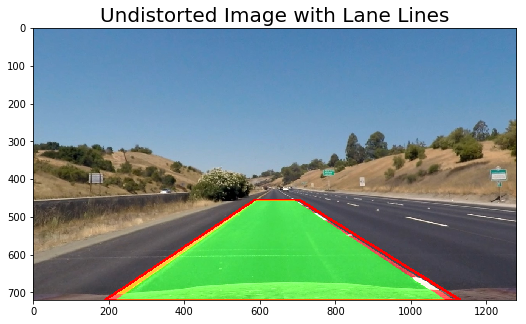

In [268]:
img_with_lanes = draw_lane_lines(undist_img, combined_sobel_img, left_fit, right_fit, M_inv)

fig, axis = plt.subplots(1, 1, figsize = (10, 5))
axis.imshow(img_with_lanes)
axis.set_title('Undistorted Image with Lane Lines', fontsize = 20)